## Predict Wine Quality 

According to the exploratory data analysis results (see EDA.Rmd), four main features have been chosen from 11 attributes:

1. volatile.acidity
2. citric.acid
3. sulphates
4. alcohol

Two other attributes also have relatively high correlation coefficients, so they should be further investigated.

5. density
6. total.sulfur.dioxide



In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read the file and create a pandas dataframe
data = pd.read_csv('wineQualityReds.csv', index_col=0)

In [4]:
# create the initial feature list
feature_cols_ini = ['volatile.acidity', 'citric.acid', 'sulphates', 'alcohol']

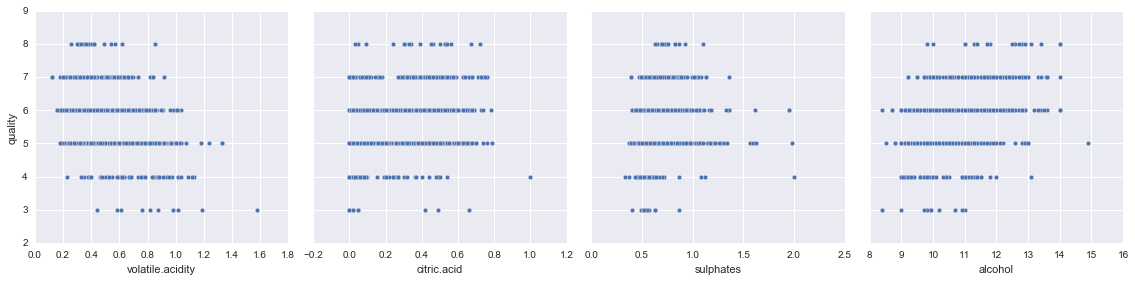

In [5]:
# plot the four main features v.s. quality
sns.pairplot(data, x_vars = feature_cols_ini, y_vars = 'quality', size=4)
sns.plt.show()

In [6]:
# feature scaling
from sklearn import preprocessing
std_scale_ini = preprocessing.StandardScaler().fit(data[feature_cols_ini])
df_std_ini = std_scale_ini.transform(data[feature_cols_ini])

In [7]:
# create X (features) and y (response)
X_ini = pd.DataFrame(data = df_std_ini, columns = feature_cols_ini)    
X_ini.index += 1
y = data['quality']

### Model Selection
Select the best model using 10-fold cross validation.

In [8]:
from sklearn.cross_validation import cross_val_score

In [9]:
# Decision Tree
# No need for feature scaling
from sklearn import tree
clf1 = tree.DecisionTreeClassifier()
DT_score = cross_val_score(clf1, data[feature_cols_ini], y, cv=10, scoring='accuracy').mean()
DT_score

0.44976641471118539

In [10]:
# Naive bayes
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
NB_score = cross_val_score(clf2, X_ini, y, cv=10, scoring='accuracy').mean()
NB_score

0.5711742507758526

In [22]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf3 = LogisticRegression()
LR_score = cross_val_score(clf3, X_ini, y, cv=10, scoring='accuracy').mean()
LR_score

0.57060365392349788

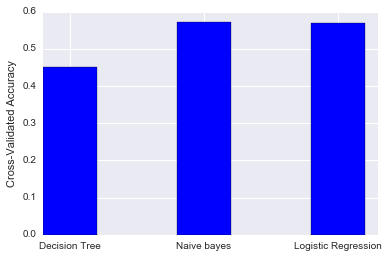

In [12]:
# plot and compare the scores
x_axis = np.arange(3)
y_axis = [DT_score, NB_score, LR_score]
plt.bar(x_axis, y_axis, width=0.4, color='blue')
plt.xticks(x_axis + 0.4/2., ('Decision Tree', 'Naive bayes', 'Logistic Regression'))
plt.ylabel('Cross-Validated Accuracy')

The default performance of decision tree is not as good as naive bayes or logistic regression.
Since naive bayes usually does not have parameters to tune, we choose **logistic regression** as the prediction model.

### Feature Selection
Study the impact of 'density' and 'total.sulfur.dioxide' on wine quality using cross validation.

In [13]:
# include 'total.sulfur.dioxide'
feature_cols1 = ['volatile.acidity', 'citric.acid', 'sulphates', 'alcohol', 'density']

In [14]:
# feature scaling and cross validation score
std_scale1 = preprocessing.StandardScaler().fit(data[feature_cols1])
df_std1 = std_scale1.transform(data[feature_cols1])
X1 = pd.DataFrame(data = df_std1, columns = feature_cols1)    
X1.index += 1
cross_val_score(clf3, X1, y, cv=10, scoring='accuracy').mean()

0.56003369466591457

In [15]:
# include 'density'
feature_cols2 = ['volatile.acidity', 'citric.acid', 'sulphates', 'alcohol', 'total.sulfur.dioxide']

In [16]:
# feature scaling and cross validation score
std_scale2 = preprocessing.StandardScaler().fit(data[feature_cols2])
df_std2 = std_scale2.transform(data[feature_cols2])
X2 = pd.DataFrame(data = df_std2, columns = feature_cols2)    
X2.index += 1
cross_val_score(clf3, X2, y, cv=10, scoring='accuracy').mean()

0.57491723703243358

Therefore, adding **'total.sulfur.dioxide'** into the feature list can improve the algorithm performance, but 'density' is not a good attribute to keep with.

### Parameters Tuning
Use GridSearchCV to tune parameter C in logistic regression. Smaller C values specify stronger regularization.

In [17]:
# the current classifier
clf = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='multinomial')
feature_cols = ['volatile.acidity', 'citric.acid', 'sulphates', 'alcohol', 'total.sulfur.dioxide']
std_scale = preprocessing.StandardScaler().fit(data[feature_cols])
df_std = std_scale.transform(data[feature_cols])
X = pd.DataFrame(data = df_std, columns = feature_cols)    
X.index += 1

In [18]:
# define the parameter values that should be searched
C_range = np.arange(0.1, 2.0, 0.1)
param_grid = dict(C = C_range)

In [19]:
# instantiate the grid, fit the grid with data
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [20]:
# examine the best model
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.590368980613
{'C': 1.0}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


In [21]:
# the final logistic regression classifier with optimal parameters
clf = LogisticRegression(penalty='l2', C = 1.0, solver='lbfgs', multi_class='multinomial')
cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean()

0.59058601686438195

### Conclusion
Logistic regression is chosen to be the best model to predict the wine quality. The mean accuracy of prediction evaluated by cross validation is 0.591. 'total.sulfur.dioxide' together with 'volatile.acidity', 'citric.acid', 'sulphates', and 'alcohol' are the major features that determine the wine quality.